In [6]:
import os
import sys
import torch
import torchvision
import torchvision.models as pt_models
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

sys.path.insert(0, "..")
from my_models import *
from qheader import *
from q1_theory import *

sys.path.insert(0, "robustness_evaluations/robustness")
from robustness.datasets import ImageNet
from robustness.model_utils import make_and_restore_model

In [7]:
configs = make_default_configs() # qheader configs
imagenet_dataset = configs["imagenet_dataset"]
exbits_list = load_exbits_list("resnet50", "shap", 0.25, configs["exbits_dir"], q=64, patch_size=28)
exbits_list = exbits_list

l2_3_0_path = "robustness_evaluations/imagenet_l2_3_0.pt"
linf_4_path = "robustness_evaluations/imagenet_linf_4.pt"
linf_8_path = "robustness_evaluations/imagenet_linf_8.pt"
assert os.path.isfile(l2_3_0_path)
assert os.path.isfile(linf_4_path)
assert os.path.isfile(linf_8_path)

base_saveto = "robustness_evaluations/resnet50_base.csv"
l2_3_0_saveto = "robustness_evaluations/WjBG_resnet50_l2_3_0.csv"
linf_4_saveto = "robustness_evaluations/WjBG_resnet50_linf_4.csv"
linf_8_saveto = "robustness_evaluations/WjBG_resnet50_linf_8.csv"

fig_saveto = "fig_robust_resnet.png"

In [8]:
resnet50_base = pt_models.resnet50(weights=pt_models.ResNet50_Weights.IMAGENET1K_V1)

ids = ImageNet("/data/imagenet/")
aresnet50_l2_3_0, _ = make_and_restore_model(arch="resnet50", dataset=ids, resume_path=l2_3_0_path)
aresnet50_linf_4, _ = make_and_restore_model(arch="resnet50", dataset=ids, resume_path=linf_4_path)
aresnet50_linf_8, _ = make_and_restore_model(arch="resnet50", dataset=ids, resume_path=linf_8_path)

mus_base = MuSImageNet(MyResNet(resnet50_base.cpu()), patch_size=28, q=64, lambd=0.25).eval()
mus_l2_3_0 = MuSImageNet(MyResNet(aresnet50_l2_3_0.model.cpu()), patch_size=28, q=64, lambd=0.25).eval()
mus_linf_4 = MuSImageNet(MyResNet(aresnet50_linf_4.model.cpu()), patch_size=28, q=64, lambd=0.25).eval()
mus_linf_8 = MuSImageNet(MyResNet(aresnet50_linf_8.model.cpu()), patch_size=28, q=64, lambd=0.25).eval()
;

=> loading checkpoint 'robustness_evaluations/imagenet_l2_3_0.pt'
=> loaded checkpoint 'robustness_evaluations/imagenet_l2_3_0.pt' (epoch 105)
=> loading checkpoint 'robustness_evaluations/imagenet_linf_4.pt'
=> loaded checkpoint 'robustness_evaluations/imagenet_linf_4.pt' (epoch 1)
=> loading checkpoint 'robustness_evaluations/imagenet_linf_8.pt'
=> loaded checkpoint 'robustness_evaluations/imagenet_linf_8.pt' (epoch 11)


''

In [4]:
base_df = q1t_test_radii(mus_base, exbits_list, imagenet_dataset, csv_saveto=base_saveto)

Will save to: robustness_evaluations/resnet50_base.csv


lam 0.2500, ones (0.0110, mu 0.2460), exbs (0.0035, mu 0.1105), : 100%|██████████| 2000/2000 [06:23<00:00,  5.22it/s]


In [5]:
l2_3_0_df = q1t_test_radii(mus_l2_3_0, exbits_list, imagenet_dataset, csv_saveto=l2_3_0_saveto)

Will save to: robustness_evaluations/WjBG_resnet50_l2_3_0.csv


lam 0.2500, ones (0.0045, mu 0.0480), exbs (0.0015, mu 0.0190), : 100%|██████████| 2000/2000 [06:22<00:00,  5.23it/s]


In [6]:
linf_4_df = q1t_test_radii(mus_linf_4, exbits_list, imagenet_dataset, csv_saveto=linf_4_saveto)

Will save to: robustness_evaluations/WjBG_resnet50_linf_4.csv


lam 0.2500, ones (0.0070, mu 0.0910), exbs (0.0040, mu 0.0390), : 100%|██████████| 2000/2000 [06:22<00:00,  5.23it/s]


In [7]:
linf_8_df = q1t_test_radii(mus_linf_8, exbits_list, imagenet_dataset, csv_saveto=linf_8_saveto)

Will save to: robustness_evaluations/WjBG_resnet50_linf_8.csv


lam 0.2500, ones (0.0055, mu 0.0425), exbs (0.0005, mu 0.0220), : 100%|██████████| 2000/2000 [06:22<00:00,  5.23it/s]


In [9]:
base_df = pd.read_csv(base_saveto)
l2_3_0_df = pd.read_csv(l2_3_0_saveto)
linf_4_df = pd.read_csv(linf_4_saveto)
linf_8_df = pd.read_csv(linf_8_saveto)

In [10]:
thr = 0.25
sum(base_df["exbs_gap"] > thr), \
    sum(l2_3_0_df["exbs_gap"] > thr), \
    sum(linf_4_df["exbs_gap"] > thr), \
    sum(linf_8_df["exbs_gap"] > thr)

(667, 846, 717, 995)

In [11]:
## Plotting stuff

In [12]:
def q1t_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    ones_gaps = (df["ones_mu_gap"] if use_mu else df["ones_gap"]).to_numpy()
    exbs_gaps = (df["exbs_mu_gap"] if use_mu else df["exbs_gap"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    todo_gaps = exbs_gaps if prop == "inc" else ones_gaps
    
    N = len(df)
    lambd = df["lambd"][0]
    cert_rs = todo_gaps / (2 * lambd)
    
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    
    if consistent:
        hit_bits = ones_labels == exbs_labels
        drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(cert_rs >= r).sum() / N for r in rs])

    return drops


In [13]:
rs = np.linspace(0.0, 2.1, 500)
base_drops_wc = q1t_drops(base_df, rs, prop="inc", consistent=True)
l2_3_0_drops_wc = q1t_drops(l2_3_0_df, rs, prop="inc", consistent=True)
linf_4_drops_wc = q1t_drops(linf_4_df, rs, prop="inc", consistent=True)
linf_8_drops_wc = q1t_drops(linf_8_df, rs, prop="inc", consistent=True)

base_drops_nc = q1t_drops(base_df, rs, prop="inc", consistent=False)
l2_3_0_drops_nc = q1t_drops(l2_3_0_df, rs, prop="inc", consistent=False)
linf_4_drops_nc = q1t_drops(linf_4_df, rs, prop="inc", consistent=False)
linf_8_drops_nc = q1t_drops(linf_8_df, rs, prop="inc", consistent=False)

<Figure size 640x480 with 0 Axes>

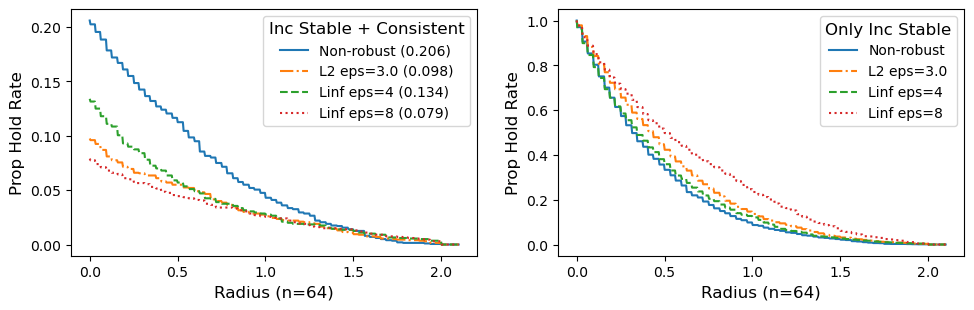

In [29]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(6.4*1.8, 3.2))

ax[0].plot(rs, base_drops_wc, linestyle="solid", label=f"Non-robust ({base_drops_wc[0]:.3f})")
ax[0].plot(rs, l2_3_0_drops_wc, linestyle="dashdot", label=f"L2 eps=3.0 ({l2_3_0_drops_wc[0]:.3f})")
ax[0].plot(rs, linf_4_drops_wc, linestyle="dashed", label=f"Linf eps=4 ({linf_4_drops_wc[0]:.3f})")
ax[0].plot(rs, linf_8_drops_wc, linestyle="dotted", label=f"Linf eps=8 ({linf_8_drops_wc[0]:.3f})")
ax[0].legend(loc="upper right", title="Inc Stable + Consistent", title_fontsize=12)
ax[0].set_ylabel("Prop Hold Rate", fontsize=12)
ax[0].set_xlabel("Radius (n=64)", fontsize=12)

ax[1].plot(rs, base_drops_nc, linestyle="solid", label=f"Non-robust")
ax[1].plot(rs, l2_3_0_drops_nc, linestyle="dashdot", label=f"L2 eps=3.0")
ax[1].plot(rs, linf_4_drops_nc, linestyle="dashed", label=f"Linf eps=4")
ax[1].plot(rs, linf_8_drops_nc, linestyle="dotted", label=f"Linf eps=8")
ax[1].legend(loc="upper right", title="Only Inc Stable", title_fontsize=12)
ax[1].set_ylabel("Prop Hold Rate", fontsize=12)
ax[1].set_xlabel("Radius (n=64)", fontsize=12)

plt.savefig(fig_saveto, bbox_inches="tight", transparent=True)